In [76]:
# !pip install jieba gensim

!pip --version

pip 24.2 from /home/frobert/.local/lib/python3.9/site-packages/pip (python 3.9)


In [8]:
import pandas as pd

posts_df = pd.read_csv("./dataset/weibo_posts_merged_eann_df.csv")

In [10]:
import re
import jieba

def clean_text(text):
    # Remove non-Chinese characters (keep Chinese, numbers, and basic punctuation)
    text = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9,，.!?！？]", "", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def segment_text(text):
    # Segment text using jieba
    words = jieba.lcut(text)
    # Join words back with spaces (useful for embeddings)
    return ' '.join(words)

# Load a list of Chinese stop words
with open('./dataset/cn_stopwords.txt', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

In [11]:
posts_df['cleaned_text'] = posts_df['text'].fillna("").apply(clean_text)
posts_df['segmented_text'] = posts_df['cleaned_text'].apply(segment_text)
posts_df['final_text'] = posts_df['segmented_text'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.606 seconds.
Prefix dict has been built successfully.


In [14]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Prepare tagged documents
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(posts_df['final_text'])]
# Train the Doc2Vec model
model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)

# Add embeddings to the DataFrame
posts_df['text_embeddings'] = posts_df['final_text'].apply(lambda x: model.infer_vector(x.split()))

In [16]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image

# Define image preprocessing transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(           # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def get_placeholder_tensor():
    return torch.zeros(3, 224, 224)  # RGB image of size 224x224

def process_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        return image_transforms(image)  # Apply transformations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def extract_images_from_folders(folder_paths, df, filename_column):
    # Initialize an empty column for image tensors
    df['image_tensor'] = None

    # Combine all folder files into a dictionary for fast lookup
    folder_files = {}
    for folder in folder_paths:
        for filename in os.listdir(folder):
            folder_files[filename] = os.path.join(folder, filename)

    # Process images and add them to the DataFrame
    for idx, row in df.iterrows():
        filename = row[filename_column]
        if filename in folder_files:
            image_path = folder_files[filename]
            df.at[idx, 'image_tensor'] = process_image(image_path)
        else:
            df.at[idx, 'image_tensor'] = get_placeholder_tensor()
            

    return df

BASE_PATH = "/home/frobert/CS688/EANN/dataset"

folder_paths = [
    BASE_PATH + "/rumor_images",
    BASE_PATH + "/nonrumor_images"
]

posts_df["filename"] = posts_df["picture_url"].str.extract(r'/([^/]+)$')

# Extract images and add tensors to DataFrame
posts_df = extract_images_from_folders(folder_paths, posts_df, "filename")

In [17]:
# Check if all text embeddings have the same shape
text_shapes = posts_df['text_embeddings'].apply(lambda x: torch.tensor(x).shape).unique()
print("Unique shapes in text embeddings:", text_shapes)

# Check if all image tensors have the same shape
image_shapes = posts_df['image_tensor'].apply(lambda x: x.shape if isinstance(x, torch.Tensor) else None).unique()
print("Unique shapes in image tensors:", image_shapes)


Unique shapes in text embeddings: [torch.Size([100])]
Unique shapes in image tensors: [torch.Size([3, 224, 224])]


In [18]:
from torch.utils.data import Dataset

class MultiModalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract text embeddings and convert to tensor
        text_embedding = torch.tensor(row['text_embeddings'], dtype=torch.float32)

        # Extract image tensor
        image_tensor = row['image_tensor']  # Already a tensor

        # Extract label
        label = torch.tensor(row['label'], dtype=torch.long)

        return text_embedding, image_tensor, label


In [35]:
from torch.utils.data import DataLoader, random_split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure the ratios sum to 1.0
assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

# Create Dataset
dataset = MultiModalDataset(posts_df)

# Compute split sizes
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate through the train DataLoader
for text_emb, img_tensor, label in train_loader:
    print("Text Embedding Shape:", text_emb.shape)
    print("Image Tensor Shape:", img_tensor.shape)
    print("Label Shape:", label.shape)
    break


Text Embedding Shape: torch.Size([32, 100])
Image Tensor Shape: torch.Size([32, 3, 224, 224])
Label Shape: torch.Size([32])


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models import vgg19

class TextFeatureExtractor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextFeatureExtractor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),  # Add BatchNorm
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # Apply fully connected block
        x = self.fc(x)
        return x

class ImageFeatureExtractor(nn.Module):
    def __init__(self, output_dim):
        super(ImageFeatureExtractor, self).__init__()
        vgg = vgg19(pretrained=True)
        self.features = vgg.features
#         resnet = resnet18(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the feature maps
        return self.fc(x)


class FakeNewsDetector(nn.Module):
    def __init__(self, text_feature_dim, image_feature_dim, combined_dim, num_classes=2):
        super(FakeNewsDetector, self).__init__()
        self.text_extractor = TextFeatureExtractor(input_dim=text_feature_dim, output_dim=combined_dim // 2)
        self.image_extractor = ImageFeatureExtractor(output_dim=combined_dim // 2)
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, text, image):
        text_features = self.text_extractor(text)
        image_features = self.image_extractor(image)
        combined_features = torch.cat((text_features, image_features), dim=1)
        return self.fc(combined_features)


In [72]:
import torch.optim as optim

# Model Parameters
TEXT_FEATURE_DIM = 100
IMAGE_FEATURE_DIM = 3
COMBINED_DIM = 256

# Training Parameters
LEARNING_RATE = 0.001

# Define loss function
criterion = nn.CrossEntropyLoss()

# Initialize model with parameterized dimensions
model = FakeNewsDetector(
    text_feature_dim=TEXT_FEATURE_DIM, 
    image_feature_dim=IMAGE_FEATURE_DIM, 
    combined_dim=COMBINED_DIM
)

# Optimizer with parameterized learning rate
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [73]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Store losses for plotting
train_losses = []
val_losses = []

num_epochs = 100

for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    # Training Phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for text_emb, img_tensor, labels in train_loader:
        text_emb, img_tensor, labels = text_emb.to(device), img_tensor.to(device), labels.to(device)

        # Forward pass
        outputs = model(text_emb, img_tensor)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct / total

    # Validation Phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for text_emb, img_tensor, labels in val_loader:
            text_emb, img_tensor, labels = text_emb.to(device), img_tensor.to(device), labels.to(device)

            # Forward pass
            outputs = model(text_emb, img_tensor)
            loss = criterion(outputs, labels)

            # Track validation metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct / total

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Training Progress:   1%|          | 1/100 [00:05<08:57,  5.43s/epoch]

Epoch 1/100, Train Loss: 0.5709, Train Accuracy: 0.6741, Val Loss: 0.5705, Val Accuracy: 0.6959


Training Progress:  11%|█         | 11/100 [00:52<07:29,  5.05s/epoch]

Epoch 11/100, Train Loss: 0.5236, Train Accuracy: 0.7417, Val Loss: 0.5271, Val Accuracy: 0.7313


Training Progress:  21%|██        | 21/100 [01:34<05:34,  4.24s/epoch]

Epoch 21/100, Train Loss: 0.5102, Train Accuracy: 0.7523, Val Loss: 0.4934, Val Accuracy: 0.7482


Training Progress:  31%|███       | 31/100 [02:25<05:29,  4.77s/epoch]

Epoch 31/100, Train Loss: 0.4969, Train Accuracy: 0.7574, Val Loss: 0.4879, Val Accuracy: 0.7468


Training Progress:  41%|████      | 41/100 [03:15<04:24,  4.49s/epoch]

Epoch 41/100, Train Loss: 0.4824, Train Accuracy: 0.7689, Val Loss: 0.4772, Val Accuracy: 0.7553


Training Progress:  51%|█████     | 51/100 [03:58<03:25,  4.20s/epoch]

Epoch 51/100, Train Loss: 0.4782, Train Accuracy: 0.7653, Val Loss: 0.4627, Val Accuracy: 0.7581


Training Progress:  61%|██████    | 61/100 [04:47<03:00,  4.63s/epoch]

Epoch 61/100, Train Loss: 0.4615, Train Accuracy: 0.7738, Val Loss: 0.4791, Val Accuracy: 0.7553


Training Progress:  71%|███████   | 71/100 [05:39<02:26,  5.05s/epoch]

Epoch 71/100, Train Loss: 0.4639, Train Accuracy: 0.7671, Val Loss: 0.4681, Val Accuracy: 0.7595


Training Progress:  81%|████████  | 81/100 [06:29<01:34,  4.97s/epoch]

Epoch 81/100, Train Loss: 0.4566, Train Accuracy: 0.7759, Val Loss: 0.4773, Val Accuracy: 0.7496


Training Progress:  91%|█████████ | 91/100 [07:16<00:45,  5.06s/epoch]

Epoch 91/100, Train Loss: 0.4397, Train Accuracy: 0.7886, Val Loss: 0.4661, Val Accuracy: 0.7624


Training Progress: 100%|██████████| 100/100 [07:58<00:00,  4.78s/epoch]


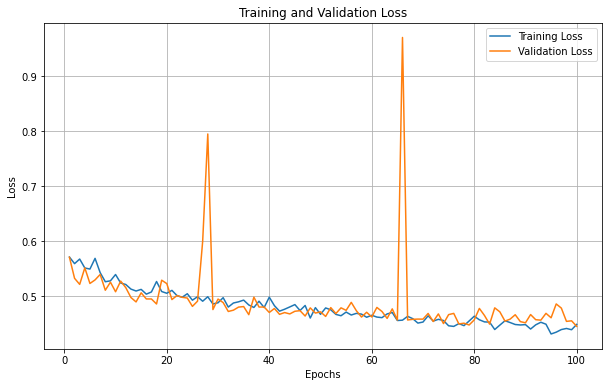

In [78]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Save the plot as an image file
plt.savefig("training_validation_loss.png", dpi=300, bbox_inches='tight')  # Save with high resolution

# Show the plot
plt.show()


In [75]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for text_emb, img_tensor, labels in test_loader:
        text_emb, img_tensor, labels = text_emb.to(device), img_tensor.to(device), labels.to(device)
        outputs = model(text_emb, img_tensor)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.7983
